In [6]:
%pip install --upgrade --quiet fastai fastcore fastdownload duckduckgo-search

Note: you may need to restart the kernel to use updated packages.


### 1. Download images of birds and non-birds

In [7]:
from duckduckgo_search import DDGS, AsyncDDGS
import asyncio

In [8]:
async def search_images(keywords, max_results=5):
    async with AsyncDDGS() as ddgs:
        results = [r['image'] async for r in ddgs.images(keywords, max_results=max_results)]
        return results

In [9]:
from fastdownload import download_url
from fastai.vision.all import *

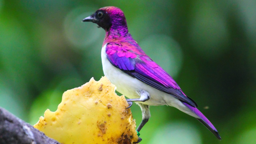

In [11]:
dest = 'temp.jpg'

r = await search_images("bird")
download_url(r[0], dest=dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

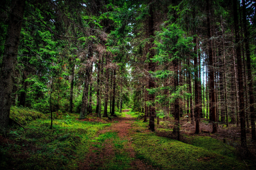

In [12]:
dest = 'temp.jpg'

r = await search_images("forest")
download_url(r[0], dest=dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

### 2. Create Dataset

In [14]:
searches = 'bird', 'forest'
path = Path('bird_or_not')
from time import sleep

for search in searches:
    dest = (path/search)
    dest.mkdir(exist_ok=True, parents=True)

    results = await search_images(f'{search} photo', max_results=5)
    download_images(dest, urls=results)
    sleep(10)

    results = await search_images(f'{search} sun photo', max_results=5)
    download_images(dest, urls=results)
    sleep(10)

    results = await search_images(f'{search} shade photo', max_results=5)
    download_images(dest, urls=results)
    sleep(10)
    resize_images(path/search, max_size=400, dest=path/search)

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

### 3. Train the model

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

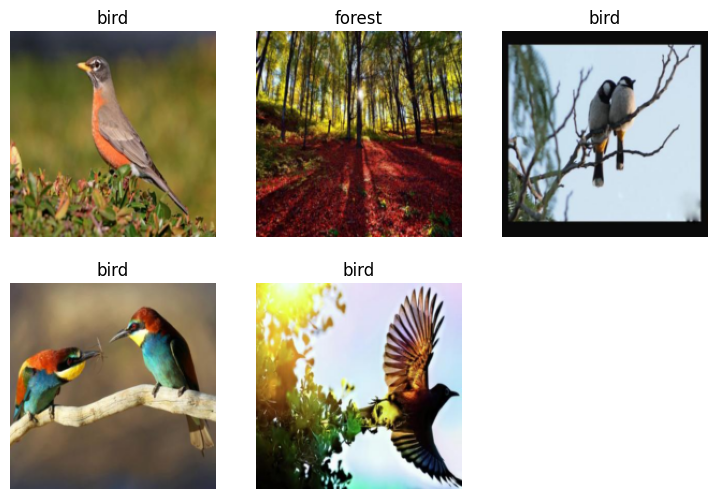

In [17]:
dls.valid.show_batch(max_n=6, nrows=2)

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,nan,1.577076,0.200000,00:00


epoch,train_loss,valid_loss,error_rate,time
0,nan,1.577076,0.200000,00:00
1,nan,1.577076,0.200000,00:00
2,nan,1.577076,0.200000,00:00


### 4. Use the Model

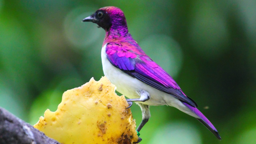

In [21]:
dest = 'bird.jpg'

r = await search_images("bird")
download_url(r[0], dest=dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256,256)

In [22]:
is_bird,_,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
